In [1]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from loader_util.preprocessing import ImageToArrayPreprocessor
from loader_util.preprocessing import AspectAwarePreprocessor
from loader_util.datasets import SimpleDatasetLoader
from loader_util.nn.conv import MinVGGNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from imutils import paths
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.axes._axes as axes
import os
sns.set()

In [2]:
# construct argument parser
dpath = r"C:\Users\mhasa\Google Drive\Tutorial Corner\PYTH\DeepLearning\DeepLearning-DL4CV\Edition3\PB_Code\datasets\flowers17\images"
args = {
    'dataset': dpath
}

print('[INFO] loading images ........')
imagePaths = list(paths.list_images(args['dataset']))
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

[INFO] loading images ........


In [3]:
# initialise the preprocessors
aap = AspectAwarePreprocessor(64, 64)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale pixels
sdl = SimpleDatasetLoader(preprocessors=[aap, iap])
data, labels = sdl.load(imagePaths, verbose=500)
data = data.astype('float') / 255.0

[INFO] processed 500/1360
[INFO] processed 1000/1360


In [4]:
# partition data into train test splits
trainx, testx, trainy, testy = train_test_split(data, labels, 
                                                test_size=0.25,
                                                random_state=42)
# convert tthe labels from integers to vectors
le = LabelBinarizer()
trainy = le.fit_transform(trainy)
testy = le.transform(testy)

# construct the image generator
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, 
                         zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

In [5]:
# initialise optimizer and compile model
print(('[INFO] compiling model ........'))
opt = SGD(learning_rate=0.05)
model = MinVGGNet.build(width=64, height=64, depth=3, classes=len(classNames))
model.compile(optimizer=opt, loss='categorical_crossentropy', 
              metrics=['accuracy'])
# train the network
H = model.fit_generator(aug.flow(trainx, trainy, batch_size=32),
                        validation_data=(testx, testy),
                        steps_per_epoch=len(trainx) // 32,
                        epochs=100, verbose=1)

[INFO] compiling model ........
Epoch 1/100
31/31 [==============================] - 8s 256ms/step - loss: 3.3906 - accuracy: 0.2004 - val_loss: 6.3952 - val_accuracy: 0.0853

[INFO] evaluating network...
              precision    recall  f1-score   support

    bluebell       0.88      0.79      0.83        19
   buttercup       0.77      0.67      0.71        15
   coltsfoot       0.48      0.60      0.53        20
     cowslip       0.50      0.83      0.62        23
      crocus       0.80      0.63      0.71        19
    daffodil       0.43      0.43      0.43        21
       daisy       0.70      0.80      0.74        20
   dandelion       0.80      0.89      0.84        27
  fritillary       0.87      0.81      0.84        16
        iris       0.94      0.80      0.86        20
  lilyvalley       0.68      0.85      0.76        20
       pansy       0.90      0.82      0.86        22
    snowdrop       0.65      0.69      0.67        16
   sunflower       1.00      0.89      0.94        18
   tigerlily       0.89      0.89      0.89        18
       tulip       0.61      0.48      0.54        23
  windflower       0.92      0.48      0.63        2

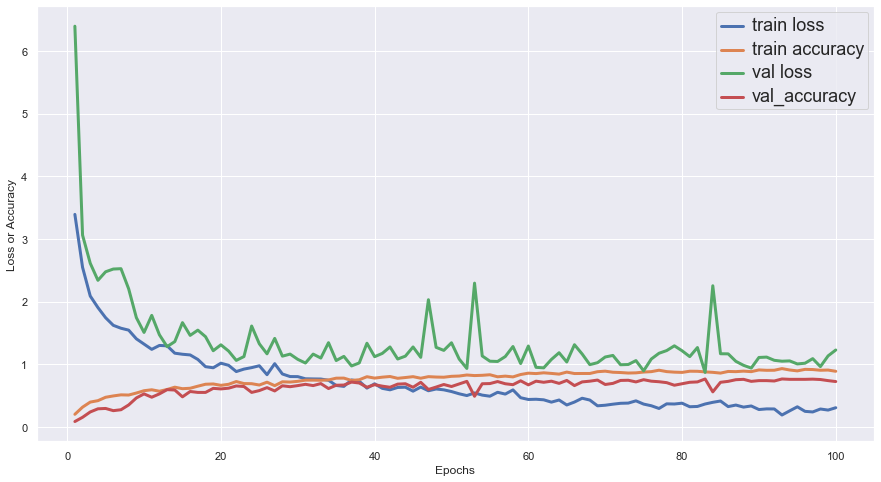

In [7]:
# evaluate the network
print ( "[INFO] evaluating network..." )
predictions = model.predict(testx, batch_size=32 )
print (classification_report(testy.argmax(axis=1 ),
predictions.argmax(axis=1 ), target_names=classNames))


# plot the performance
epochs = range(1,101)
loss = H.history['loss']
accuracy = H.history['accuracy']
val_loss = H.history['val_loss']
val_accuracy = H.history['val_accuracy']
plot_df = pd.DataFrame(data=np.c_[epochs,loss,accuracy,val_loss,val_accuracy], 
                       columns=['epochs','loss', 'accuracy', 'val_loss', 'val_accuracy'])

# do the actual plots
sns.set(font_scale=1)
f, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(data=plot_df, x='epochs', y='loss', ax=ax, label='train loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='accuracy', ax=ax, label='train accuracy', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_loss', ax=ax, label='val loss', linewidth=3)
sns.lineplot(data=plot_df, x='epochs', y='val_accuracy', ax=ax, label='val_accuracy', linewidth=3)
ax.set_ylabel('Loss or Accuracy')
ax.set_xlabel('Epochs')
plt.setp(ax.get_legend().get_texts(), fontsize='18'); # for legend text